#Importing dependencies


In [36]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [37]:
#from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

# loading the dataset and data exploration



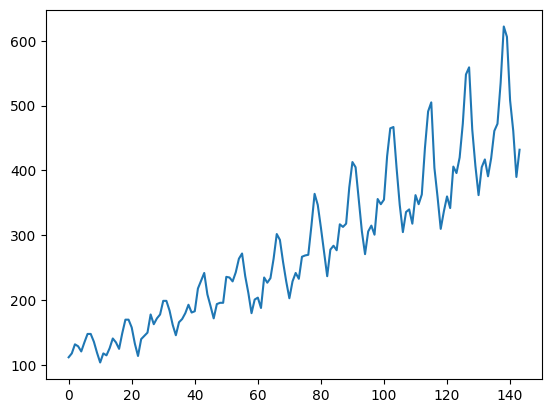

In [38]:
dataframe = read_csv('AirPassengers.csv', usecols=[1])
plt.plot(dataframe)

# Preprocessing the data to make it compatible fot the Neural Network

In [39]:
#Convert pandas dataframe to numpy array
#COnvert values to float
dataset = dataframe.values
dataset = dataset.astype('float32') 


In [40]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset for the model to undertand patterns in a better way
scaler = MinMaxScaler(feature_range=(0, 1)) 
#Also try QuantileTransformer
dataset = scaler.fit_transform(dataset)


We cannot use random way of splitting dataset into train and test as
the sequence of events is important for time series.
So let us take first 60% values for train and the remaining 1/3 for testing
Split into train and test sets

In [41]:
train_size = int(len(dataset) * 0.66)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

We cannot fit the model like we normally do for image processing where we have
X and Y. We need to transform our data into something that looks like X and Y values.
* This way it can be trained on a sequence rather than indvidual datapoints. 
Let us convert into n number of columns for X where we feed sequence of numbers
then the final column as Y where we provide the next number in the sequence as output.
* So let us convert an array of values into a dataset matrix
seq_size is the number of previous time steps to use as 
input variables to predict the next time period.

* creates a dataset where X is the number of passengers at a given time (t, t-1, t-2...) and Y is the number of passengers at the next time (t + 1).

In [42]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)

In [43]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_1, trainY_1 = to_sequences(train, seq_size)
testX_1, testY_1 = to_sequences(test, seq_size)

print("Shape of training set: {}".format(trainX_1.shape))
print("Shape of test set: {}".format(testX_1.shape))

Shape of training set: (84, 10)
Shape of test set: (38, 10)


# Single LSTM

In [44]:
# Reshape input to be [samples, time steps, features]
trainX_1 = np.reshape(trainX_1, (trainX_1.shape[0], 1, trainX_1.shape[1]))
testX_1 = np.reshape(testX_1, (testX_1.shape[0], 1, testX_1.shape[1]))

#creaing model with a single LSTM
print('Single LSTM with hidden Dense...')
model = Sequential()
model.add(LSTM(64, input_shape=(None, seq_size)))
model.add(Dense(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
##monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=20, 
##                        verbose=1, mode='auto', restore_best_weights=True)
print('Train...')

Single LSTM with hidden Dense...
Train...


In [45]:
#Setting parameteres for fiitnig the model
model.fit(trainX_1, trainY_1, validation_data=(testX_1, testY_1),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 4s - loss: 0.0444 - val_loss: 0.1797 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0240 - val_loss: 0.0970 - 94ms/epoch - 31ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0114 - val_loss: 0.0450 - 70ms/epoch - 23ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0062 - val_loss: 0.0247 - 87ms/epoch - 29ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0074 - val_loss: 0.0237 - 66ms/epoch - 22ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0095 - val_loss: 0.0244 - 71ms/epoch - 24ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0092 - val_loss: 0.0226 - 66ms/epoch - 22ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0072 - val_loss: 0.0228 - 64ms/epoch - 21ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0057 - val_loss: 0.0265 - 70ms/epoch - 23ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0053 - val_loss: 0.0313 - 68ms/epoch - 23ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0056 - val_loss: 0.0337 - 65ms/epoch - 22ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0057 - val_loss: 0.0318 - 53ms/epoch - 18ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0053 - va

In [46]:
# making predictions
trainPredict_1 = model.predict(trainX_1)
testPredict_1 = model.predict(testX_1)

2/2 [==============================] - 0s 6ms/step


In [47]:
# Invert predictions back to prescaled values This is to compare with original input values
#Since we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_1 = scaler.inverse_transform(trainPredict_1)
trainY_1 = scaler.inverse_transform([trainY_1])
testPredict_1 = scaler.inverse_transform(testPredict_1)
testY_1 = scaler.inverse_transform([testY_1])


In [48]:
# calculate root mean squared error
trainScore_1 = math.sqrt(mean_squared_error(trainY_1[0], trainPredict_1[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_1))

testScore_1 = math.sqrt(mean_squared_error(testY_1[0], testPredict_1[:,0]))
print('Test Score: %.2f RMSE' % (testScore_1))

Train Score: 19.01 RMSE
Test Score: 39.63 RMSE


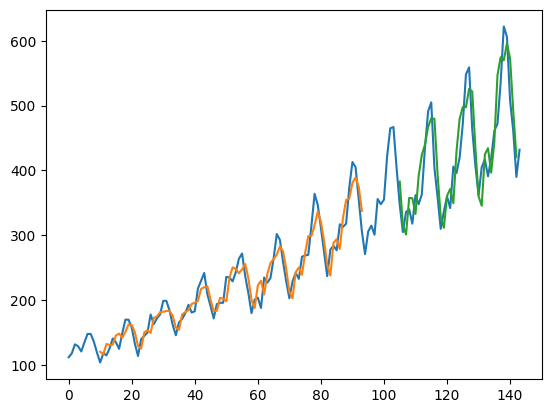

In [49]:
# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_1 = np.empty_like(dataset)
trainPredictPlot_1[:, :] = np.nan
trainPredictPlot_1[seq_size:len(trainPredict_1)+seq_size, :] = trainPredict_1

# shift test predictions for plotting
testPredictPlot_1 = np.empty_like(dataset)
testPredictPlot_1[:, :] = np.nan
testPredictPlot_1[len(trainPredict_1)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_1

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot_1)
plt.plot(testPredictPlot_1)
plt.show()

# Stacked LSTM

In [50]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_2, trainY_2 = to_sequences(train, seq_size)
testX_2, testY_2 = to_sequences(test, seq_size)

#Stacked LSTM with 1 hidden dense layer
#reshape input to be [samples, time steps, features]
trainX_2 = np.reshape(trainX_2, (trainX_2.shape[0], 1, trainX_2.shape[1]))
testX_2 = np.reshape(testX_2, (testX_2.shape[0], 1, testX_2.shape[1]))

model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, seq_size)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()
print('Train...')

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, None, 50)          12200     
                                                                 
 lstm_6 (LSTM)               (None, 50)                20200     
                                                                 
 dense_9 (Dense)             (None, 32)                1632      
                                                                 
 dense_10 (Dense)            (None, 1)                 33        
                                                                 
Total params: 34,065
Trainable params: 34,065
Non-trainable params: 0
_________________________________________________________________
Train...


In [51]:
#Setting parameteres for fiitnig the model
model.fit(trainX_2, trainY_2, validation_data=(testX_2, testY_2),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 4s - loss: 0.0612 - val_loss: 0.3258 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0468 - val_loss: 0.2768 - 72ms/epoch - 24ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0352 - val_loss: 0.2284 - 54ms/epoch - 18ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0248 - val_loss: 0.1817 - 60ms/epoch - 20ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0180 - val_loss: 0.1382 - 52ms/epoch - 17ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0141 - val_loss: 0.1015 - 79ms/epoch - 26ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0128 - val_loss: 0.0747 - 70ms/epoch - 23ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0139 - val_loss: 0.0587 - 71ms/epoch - 24ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0145 - val_loss: 0.0539 - 69ms/epoch - 23ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0141 - val_loss: 0.0559 - 63ms/epoch - 21ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0129 - val_loss: 0.0610 - 48ms/epoch - 16ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0117 - val_loss: 0.0672 - 68ms/epoch - 23ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0109 - va

In [52]:
# making predictions
trainPredict_2 = model.predict(trainX_2)
testPredict_2 = model.predict(testX_2)

2/2 [==============================] - 0s 6ms/step


Train Score: 19.19 RMSE
Test Score: 60.49 RMSE


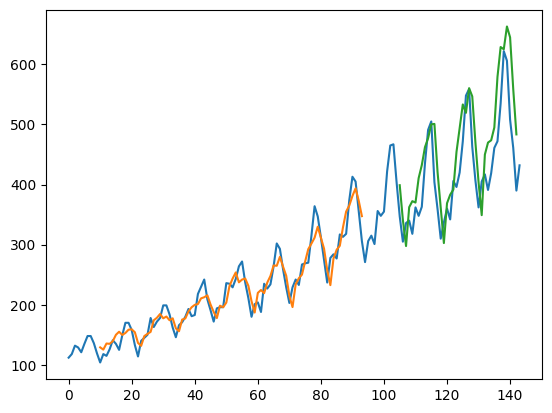

In [53]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_2 = scaler.inverse_transform(trainPredict_2)
trainY_2 = scaler.inverse_transform([trainY_2])
testPredict_2 = scaler.inverse_transform(testPredict_2)
testY_2 = scaler.inverse_transform([testY_2])

# calculate root mean squared error
trainScore_2 = math.sqrt(mean_squared_error(trainY_2[0], trainPredict_2[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_2))

testScore_2 = math.sqrt(mean_squared_error(testY_2[0], testPredict_2[:,0]))
print('Test Score: %.2f RMSE' % (testScore_2))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_2 = np.empty_like(dataset)
trainPredictPlot_2[:, :] = np.nan
trainPredictPlot_2[seq_size:len(trainPredict_2)+seq_size, :] = trainPredict_2

# shift test predictions for plotting
testPredictPlot_2 = np.empty_like(dataset)
testPredictPlot_2[:, :] = np.nan
testPredictPlot_2[len(trainPredict_2)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_2

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot_2)
plt.plot(testPredictPlot_2)
plt.show()


#Bidirection LSTM

In [54]:
seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_3, trainY_3 = to_sequences(train, seq_size)
testX_3, testY_3 = to_sequences(test, seq_size)

#Bidirectional LSTM
#reshape input to be [samples, time steps, features]
trainX_3 = np.reshape(trainX_3, (trainX_3.shape[0], 1, trainX_3.shape[1]))
testX_3 = np.reshape(testX_3, (testX_3.shape[0], 1, testX_3.shape[1]))

#For some sequence forecasting problems we may need LSTM to learn
# sequence in both forward and backward directions
from keras.layers import Bidirectional
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(None, seq_size)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
print('Train...')

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_1 (Bidirectio  (None, 100)              24400     
 nal)                                                            
                                                                 
 dense_11 (Dense)            (None, 1)                 101       
                                                                 
Total params: 24,501
Trainable params: 24,501
Non-trainable params: 0
_________________________________________________________________
Train...


In [55]:
#Setting parameteres for fiitnig the model
model.fit(trainX_3, trainY_3, validation_data=(testX_3, testY_3),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 3s - loss: 0.0670 - val_loss: 0.3549 - 3s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0587 - val_loss: 0.3108 - 49ms/epoch - 16ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0506 - val_loss: 0.2693 - 65ms/epoch - 22ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0430 - val_loss: 0.2303 - 67ms/epoch - 22ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0361 - val_loss: 0.1941 - 70ms/epoch - 23ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0300 - val_loss: 0.1600 - 67ms/epoch - 22ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0239 - val_loss: 0.1292 - 79ms/epoch - 26ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0191 - val_loss: 0.1011 - 63ms/epoch - 21ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0149 - val_loss: 0.0765 - 47ms/epoch - 16ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0113 - val_loss: 0.0564 - 41ms/epoch - 14ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0085 - val_loss: 0.0410 - 44ms/epoch - 15ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0070 - val_loss: 0.0307 - 44ms/epoch - 15ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0058 - va

In [56]:
# making predictions
trainPredict_3 = model.predict(trainX_3)
testPredict_3 = model.predict(testX_3)

2/2 [==============================] - 0s 10ms/step


Train Score: 25.28 RMSE
Test Score: 64.17 RMSE


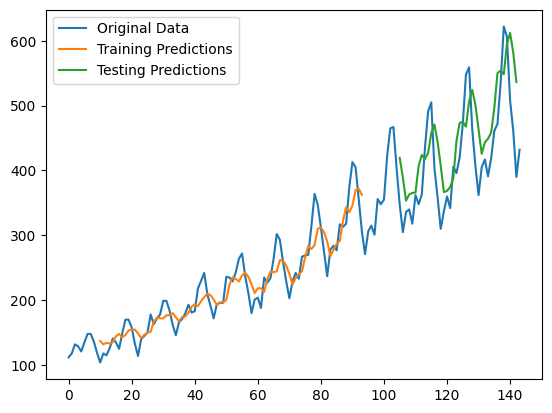

In [57]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_3 = scaler.inverse_transform(trainPredict_3)
trainY_3 = scaler.inverse_transform([trainY_3])
testPredict_3 = scaler.inverse_transform(testPredict_3)
testY_3 = scaler.inverse_transform([testY_3])

# calculate root mean squared error
trainScore_3 = math.sqrt(mean_squared_error(trainY_3[0], trainPredict_3[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_3))

testScore_3 = math.sqrt(mean_squared_error(testY_3[0], testPredict_3[:,0]))
print('Test Score: %.2f RMSE' % (testScore_3))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_3 = np.empty_like(dataset)
trainPredictPlot_3[:, :] = np.nan
trainPredictPlot_3[seq_size:len(trainPredict_3)+seq_size, :] = trainPredict_3

# shift test predictions for plotting
testPredictPlot_3 = np.empty_like(dataset)
testPredictPlot_3[:, :] = np.nan
testPredictPlot_3[len(trainPredict_3)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_3

import matplotlib.pyplot as plt

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot_3, label='Training Predictions')
plt.plot(testPredictPlot_3, label='Testing Predictions')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Convolution LSTM 

In [58]:
def to_sequences(dataset, seq_size=1):
    x = []
    y = []

    for i in range(len(dataset)-seq_size-1):
        #print(i)
        window = dataset[i:(i+seq_size), 0]
        x.append(window)
        y.append(dataset[i+seq_size, 0])
        
    return np.array(x),np.array(y)
    

seq_size = 10  # Number of time steps to look back 
#Larger sequences (look further back) may improve forecasting.

trainX_4, trainY_4 = to_sequences(train, seq_size)
testX_4, testY_4 = to_sequences(test, seq_size)


print("Shape of training set: {}".format(trainX_4.shape))
print("Shape of test set: {}".format(testX_4.shape))



Shape of training set: (84, 10)
Shape of test set: (38, 10)


In [59]:
#ConvLSTM
#The layer expects input as a sequence of two-dimensional images, 
#therefore the shape of input data must be: [samples, timesteps, rows, columns, features]

trainX_4 = trainX_4.reshape((trainX_4.shape[0], 1, 1, 1, seq_size))
testX_4 = testX_4.reshape((testX_4.shape[0], 1, 1, 1, seq_size))

model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,1), activation='relu', input_shape=(1, 1, 1, seq_size)))
model.add(Flatten())
model.add(Dense(32))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()
#print('Train...')


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_1 (ConvLSTM2D)  (None, 1, 1, 64)          19200     
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 1)                 33        
                                                                 
Total params: 21,313
Trainable params: 21,313
Non-trainable params: 0
_________________________________________________________________


In [60]:
#Setting parameteres for fiitnig the model
model.fit(trainX_4, trainY_4, validation_data=(testX_4, testY_4),
          verbose=2, epochs=100)

Epoch 1/100
3/3 - 4s - loss: 0.0632 - val_loss: 0.3089 - 4s/epoch - 1s/step
Epoch 2/100
3/3 - 0s - loss: 0.0444 - val_loss: 0.2342 - 67ms/epoch - 22ms/step
Epoch 3/100
3/3 - 0s - loss: 0.0296 - val_loss: 0.1697 - 53ms/epoch - 18ms/step
Epoch 4/100
3/3 - 0s - loss: 0.0192 - val_loss: 0.1160 - 67ms/epoch - 22ms/step
Epoch 5/100
3/3 - 0s - loss: 0.0125 - val_loss: 0.0749 - 48ms/epoch - 16ms/step
Epoch 6/100
3/3 - 0s - loss: 0.0095 - val_loss: 0.0478 - 48ms/epoch - 16ms/step
Epoch 7/100
3/3 - 0s - loss: 0.0091 - val_loss: 0.0339 - 47ms/epoch - 16ms/step
Epoch 8/100
3/3 - 0s - loss: 0.0101 - val_loss: 0.0285 - 64ms/epoch - 21ms/step
Epoch 9/100
3/3 - 0s - loss: 0.0107 - val_loss: 0.0271 - 49ms/epoch - 16ms/step
Epoch 10/100
3/3 - 0s - loss: 0.0101 - val_loss: 0.0284 - 71ms/epoch - 24ms/step
Epoch 11/100
3/3 - 0s - loss: 0.0089 - val_loss: 0.0317 - 51ms/epoch - 17ms/step
Epoch 12/100
3/3 - 0s - loss: 0.0080 - val_loss: 0.0365 - 72ms/epoch - 24ms/step
Epoch 13/100
3/3 - 0s - loss: 0.0074 - va

In [61]:
# making predictions
trainPredict_4 = model.predict(trainX_4)
testPredict_4 = model.predict(testX_4)

2/2 [==============================] - 0s 6ms/step


Train Score: 19.99 RMSE
Test Score: 47.53 RMSE


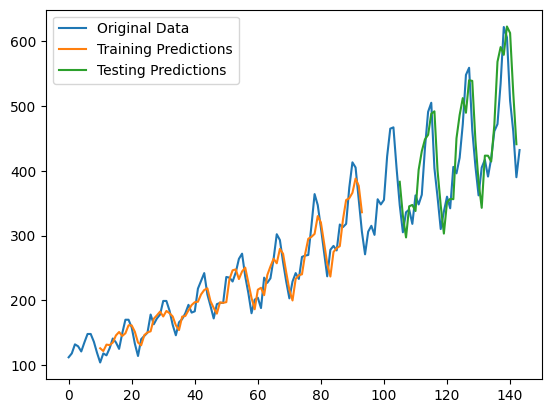

In [62]:
# invert predictions back to prescaled values
#This is to compare with original input values
#SInce we used minmaxscaler we can now use scaler.inverse_transform
#to invert the transformation.
trainPredict_4 = scaler.inverse_transform(trainPredict_4)
trainY_4 = scaler.inverse_transform([trainY_4])
testPredict_4 = scaler.inverse_transform(testPredict_4)
testY_4 = scaler.inverse_transform([testY_4])

# calculate root mean squared error
trainScore_4 = math.sqrt(mean_squared_error(trainY_4[0], trainPredict_4[:,0]))
print('Train Score: %.2f RMSE' % (trainScore_4))

testScore_4 = math.sqrt(mean_squared_error(testY_4[0], testPredict_4[:,0]))
print('Test Score: %.2f RMSE' % (testScore_4))

# shift train predictions for plotting
#we must shift the predictions so that they align on the x-axis with the original dataset. 
trainPredictPlot_4 = np.empty_like(dataset)
trainPredictPlot_4[:, :] = np.nan
trainPredictPlot_4[seq_size:len(trainPredict_4)+seq_size, :] = trainPredict_4

# shift test predictions for plotting
testPredictPlot_4 = np.empty_like(dataset)
testPredictPlot_4[:, :] = np.nan
testPredictPlot_4[len(trainPredict_4)+(seq_size*2)+1:len(dataset)-1, :] = testPredict_4
import matplotlib.pyplot as plt

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), label='Original Data')
plt.plot(trainPredictPlot_4, label='Training Predictions')
plt.plot(testPredictPlot_4, label='Testing Predictions')

# Add legend
plt.legend()

# Display the plot
plt.show()

#Comparing the RMSE scores of Single LSTM, Stacked LSTM, Bidirectional LSTM and  Convolutional LSTM

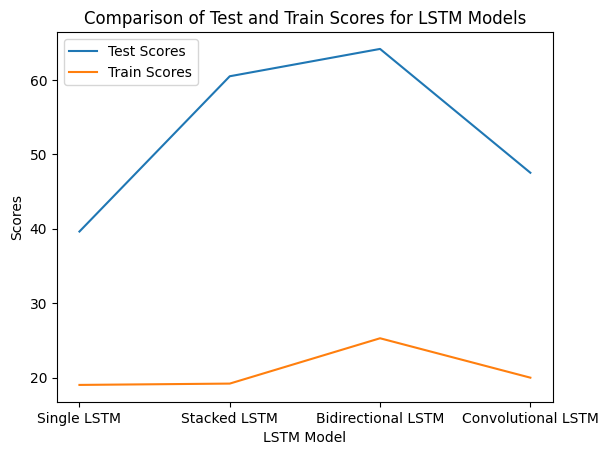

In [63]:
import matplotlib.pyplot as plt

# Test and train scores for each LSTM model
test_scores = [testScore_1, testScore_2, testScore_3, testScore_4]
train_scores = [trainScore_1, trainScore_2, trainScore_3, trainScore_4]

# Model labels
model_labels = ['Single LSTM', 'Stacked LSTM', 'Bidirectional LSTM', 'Convolutional LSTM']

# Plotting the scores
plt.plot(model_labels, test_scores, label='Test Scores')
plt.plot(model_labels, train_scores, label='Train Scores')

# Add labels and title
plt.xlabel('LSTM Model')
plt.ylabel('Scores')
plt.title('Comparison of Test and Train Scores for LSTM Models')

# Add legend
plt.legend()

# Display the plot
plt.show()
